In [64]:
!python3 --version

In [65]:
%pip install wandb -qU

Note: you may need to restart the kernel to use updated packages.


In [1]:
import wandb

In [2]:
wandb.login()

wandb: Currently logged in as: kalimullin414 (neuroml2023). Use `wandb login --relogin` to force relogin


True

In [3]:
run = wandb.init(project="img2img-pix2pix",
                 config={"learning_rate": 2e-4 ,
                         "num_epochs": 300})

In [4]:
%pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://download.pytorch.org/whl/torch_stable.html

[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch 
torch. __version__ 

'1.9.0+cu111'

In [5]:
import torchvision
torchvision. __version__

'0.10.0+cu111'

In [6]:
torch.cuda.is_available()

True

In [7]:
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import functools
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.autograd import Variable
from torchvision.utils import save_image
# from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
import time
from sklearn.model_selection import train_test_split
import pylab as pl
from IPython import display
import logging
import os
import shutil
import sys
import torch.nn as nn
import tempfile
import random
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import torch
from urllib.request import urlretrieve
import gzip
from PIL import Image
import pathlib
from pathlib import Path
import pandas as pd
from IPython.display import clear_output

In [9]:
SEED = 1380
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
# random.seed(SEED)
# os.environ['PYTHONHASHSEED'] = str(SEED)

In [10]:
task_fmri_path ="/trinity/home/ruslan.kalimullin/Image_to_image/data"
rest_state_path ="/trinity/home/ruslan.kalimullin/Image_to_image/data"

In [10]:
!nvidia-smi

Mon Dec 11 16:00:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.108.03   Driver Version: 510.108.03   CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:C7:00.0 Off |                    0 |
| N/A   29C    P0    60W / 400W |      2MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
os.listdir(rest_state_path)

['545345_tfMRI_MOTOR_LR.csv',
 '134223_rfMRI_REST1_LR.csv',
 '130619_tfMRI_MOTOR_LR.csv',
 '172938_rfMRI_REST1_LR.csv',
 '176845_tfMRI_MOTOR_LR.csv',
 '149842_rfMRI_REST1_LR.csv',
 '161731_rfMRI_REST1_LR.csv',
 '732243_rfMRI_REST1_LR.csv',
 '147030_tfMRI_MOTOR_LR.csv',
 '448347_tfMRI_MOTOR_LR.csv',
 '172332_tfMRI_MOTOR_LR.csv',
 '153934_tfMRI_MOTOR_LR.csv',
 '685058_tfMRI_MOTOR_LR.csv',
 '281135_tfMRI_MOTOR_LR.csv',
 '353740_rfMRI_REST1_LR.csv',
 '204622_rfMRI_REST1_LR.csv',
 '581450_rfMRI_REST1_LR.csv',
 '149337_rfMRI_REST1_LR.csv',
 '694362_tfMRI_MOTOR_LR.csv',
 '129331_tfMRI_MOTOR_LR.csv',
 '119732_tfMRI_MOTOR_LR.csv',
 '136227_rfMRI_REST1_LR.csv',
 '162228_rfMRI_REST1_LR.csv',
 '627549_rfMRI_REST1_LR.csv',
 '665254_rfMRI_REST1_LR.csv',
 '217126_tfMRI_MOTOR_LR.csv',
 '170934_tfMRI_MOTOR_LR.csv',
 '100307_tfMRI_MOTOR_LR.csv',
 '151526_tfMRI_MOTOR_LR.csv',
 '414229_rfMRI_REST1_LR.csv',
 '385450_rfMRI_REST1_LR.csv',
 '214726_tfMRI_MOTOR_LR.csv',
 '304020_rfMRI_REST1_LR.csv',
 '552241_r

In [11]:
class FMRIConnectivityDataset(Dataset):
    def __init__(self, rest_data_directory,task_data_directory, ids, transform=None):
        self.transform = transform
        self.data = [] 

        for subject_id in ids:
            rest_file_path = os.path.join(rest_data_directory, f"{subject_id}_rfMRI_REST1_LR.csv")
            motor_file_path = os.path.join(task_data_directory, f"{subject_id}_tfMRI_MOTOR_LR.csv")

            if os.path.exists(rest_file_path) and os.path.exists(motor_file_path):
                rest_data = pd.read_csv(rest_file_path)
                motor_data = pd.read_csv(motor_file_path)

                self.data.append((subject_id, rest_data.values, motor_data.values))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        subject_id, rest_fMRI_matrix, motor_task_fMRI_matrix = self.data[idx]

        data_dict = {
            "subject_id": subject_id,
            "rest_fMRI_data": torch.FloatTensor(rest_fMRI_matrix[np.newaxis,:,:]),
            "motor_task_fMRI_data": torch.FloatTensor(motor_task_fMRI_matrix[np.newaxis,:,:])
        }

        return data_dict

In [12]:

file_names_rs = [f for f in os.listdir(rest_state_path) if f.endswith(".csv")]
file_names_tb = [f for f in os.listdir(task_fmri_path) if f.endswith(".csv")]

In [13]:
file_ids_rs = list(set([file.split('_')[0] for file in file_names_rs]))
file_ids_tb = list(set([file.split('_')[0] for file in file_names_tb]))

In [14]:
file_ids =set(file_ids_rs) & set(file_ids_tb)

In [26]:
seed = 1380

# Set seed for PyTorch
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set seed for NumPy
np.random.seed(seed)

train_ratio = 0.8
test_ratio = 0.2

file_ids_train, file_ids_test = train_test_split(list(file_ids), test_size=test_ratio, random_state=seed)

train_dataset = FMRIConnectivityDataset(rest_state_path, task_fmri_path, file_ids_train)
test_dataset = FMRIConnectivityDataset(rest_state_path, task_fmri_path, file_ids_test)

batch_size = 1
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [16]:
# train_dataset = FMRIConnectivityDataset(rest_state_path,task_fmri_path, train_ids)
# test_dataset = FMRIConnectivityDataset(rest_state_path,task_fmri_path, test_ids)

# batch_size = 1
# train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [27]:
print("File IDs in the test data loader:")
for batch in test_data_loader:
    file_ids_batch = batch['subject_id']
    print(file_ids_batch)

File IDs in the test data loader:
['307127']
['361234']
['547046']
['134829']
['119126']
['145834']
['165032']
['295146']
['133019']
['627852']
['132017']
['467351']
['239136']
['180230']
['614439']
['199150']
['613538']
['654552']
['358144']
['365343']
['568963']
['112112']
['168947']
['135730']
['304727']
['214221']
['124826']
['105216']
['146937']
['671855']
['205826']
['281135']
['304020']
['148133']
['727654']
['135629']
['141826']
['729254']
['255740']
['665254']
['360030']
['133928']
['573249']
['123925']
['199453']
['198249']
['135124']
['394956']
['186545']
['113316']
['298455']
['233326']
['131217']
['693764']
['553344']
['158540']
['165638']
['627549']
['395251']
['189652']
['685058']
['197550']
['393550']
['198451']
['645551']
['175439']
['205725']
['376247']
['316633']
['129028']
['599671']
['147030']
['192136']
['202113']
['617748']
['191033']
['127630']
['581450']
['122822']
['475855']
['570243']
['101410']
['162228']
['573451']
['284646']
['208125']
['701535']
['169343'

In [30]:
seed = 1380

# Set seed for PyTorch
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set seed for NumPy
np.random.seed(seed)

train_ratio = 0.8
test_ratio = 0.2

file_ids_train, file_ids_test = train_test_split(list(file_ids), test_size=test_ratio, random_state=seed)

train_dataset = FMRIConnectivityDataset(rest_state_path, task_fmri_path, file_ids_train)
test_dataset = FMRIConnectivityDataset(rest_state_path, task_fmri_path, file_ids_test)

batch_size = 1
# Disable shuffle for reproducibility
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("File IDs in the test data loader:")
for batch in test_data_loader:
    file_ids_batch = batch['subject_id']
    print(file_ids_batch)


File IDs in the test data loader:
['614439']
['199453']
['127630']
['197550']
['191033']
['148133']
['547046']
['393550']
['381038']
['119126']
['182032']
['233326']
['208125']
['627549']
['123925']
['255740']
['147636']
['317332']
['141826']
['144832']
['475855']
['680957']
['155635']
['638049']
['150726']
['573249']
['135629']
['298455']
['360030']
['198451']
['186545']
['352738']
['599671']
['122317']
['188145']
['126426']
['245333']
['671855']
['129028']
['162026']
['304727']
['701535']
['175439']
['199150']
['304020']
['729254']
['158540']
['115017']
['132017']
['195445']
['164030']
['715950']
['106016']
['133928']
['214221']
['192136']
['147030']
['189652']
['198249']
['395251']
['468050']
['387959']
['180230']
['685058']
['239136']
['146432']
['105216']
['316633']
['183034']
['467351']
['358144']
['112112']
['196750']
['195849']
['205725']
['394956']
['188448']
['617748']
['165638']
['101410']
['156334']
['135124']
['134829']
['361234']
['165032']
['153934']
['145834']
['113316'

In [ ]:
for batch in test_data_loader:
    keys_in_batch = batch.keys()
    print("Keys in the batch:", keys_in_batch)

## Initialize generator

In [32]:
# custom weights initialization called on generator and discriminator        
def weights_init(net, init_type='normal', scaling=0.02):
    """Initialize network weights.
    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.
    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv')) != -1:
            torch.nn.init.normal_(m.weight.data, 0.0, scaling)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            torch.nn.init.normal_(m.weight.data, 1.0, scaling)
            torch.nn.init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function <init_func>

In [33]:
def get_norm_layer():
    """Return a normalization layer
       For BatchNorm, we use learnable affine parameters and track running statistics (mean/stddev).
    """
    norm_type = 'batch'
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)
    return norm_layer

In [34]:
class UnetGenerator(nn.Module):
    """Create a Unet-based generator"""

    def __init__(self, input_nc, output_nc, nf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet generator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
                                image of size 128x128 will become of size 1x1 # at the bottleneck
            nf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer
        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        super(UnetGenerator, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)  # add the innermost layer
        
        # add intermediate layers with ngf * 8 filters
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        
        # gradually reduce the number of filters from nf * 8 to nf
        unet_block = UnetSkipConnectionBlock(nf * 4, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(nf * 2, nf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(nf, nf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        self.model = UnetSkipConnectionBlock(output_nc, nf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  # add the outermost layer

    def forward(self, input):
        """Standard forward"""
        return self.model(input)

In [35]:
class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet submodule with skip connections.
        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)

In [36]:
norm_layer = get_norm_layer()

In [37]:
class UnetSkipConnectionBlock(nn.Module):
    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if input_nc is None:
            input_nc = outer_nc

        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=3, stride=1, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)

        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            # Modify the kernel size for the outermost upconv layer
            upconv = nn.ConvTranspose2d(inner_nc*2, outer_nc,
                                        kernel_size=3, stride=1, padding=1)  # Adjusted kernel_size and stride
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=3, stride=1,
                                        padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc*2, outer_nc,
                                        kernel_size=3, stride=1,
                                        padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            model_x = self.model(x)
            # print("x size:", x.size())
            # print("model_x size:", model_x.size())
            return torch.cat([x, model_x], 1)

In [38]:
device = 'cuda:0'
norm_layer = get_norm_layer()

# Create the generator
generator = UnetGenerator(1, 1, 64, norm_layer=norm_layer, use_dropout=False)
generator.apply(lambda x: weights_init(x, init_type='normal', scaling=0.02))
generator = generator.to(device)
# generator = torch.nn.DataParallel(generator)
inp = torch.ones(1, 1, 400, 400)
inp = inp.to(device)

# Debug 
print("Input Tensor Size:", inp.size())

# Generate output
gen = generator(inp)

# Debug 
print("Generated Tensor Size:", gen.size())

initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initiali

## Initialize Discriminator

In [39]:
class Discriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(Discriminator, self).__init__()
        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=False),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=False),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw), nn.Sigmoid()]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)

In [40]:
discriminator = Discriminator(2, 64, n_layers=3, norm_layer=norm_layer)#.cuda().float()
discriminator.apply(weights_init)
# discriminator = torch.nn.DataParallel(discriminator)  # multi-GPUs

initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal


Discriminator(
  (model): Sequential(
    (0): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (12): Sigmoid()
  )
)

In [41]:
discriminator=discriminator.cuda()

In [42]:
inp = torch.ones(1,2,400,400).cuda()
disc = discriminator(inp)

In [43]:
disc.shape

torch.Size([1, 1, 48, 48])

In [44]:
adversarial_loss = nn.BCELoss() 
l1_loss = nn.L1Loss()

In [45]:
def generator_loss(generated_image, target_img, G, real_target):
    gen_loss = adversarial_loss(G, real_target)
    l1_l = l1_loss(generated_image, target_img)
    gen_total_loss = gen_loss + (100 * l1_l)
    #print(gen_loss)
    return gen_total_loss

In [46]:
def discriminator_loss(output, label):
    disc_loss = adversarial_loss(output, label)
    return disc_loss

In [47]:
learning_rate = 2e-4 
G_optimizer = optim.Adam(generator.parameters(), lr = learning_rate, betas=(0.5, 0.999))
D_optimizer = optim.Adam(discriminator.parameters(), lr = learning_rate, betas=(0.5, 0.999))

In [48]:
import random
from itertools import cycle

def sample_fMRI_data(data_loader):
    """
    Sample a batch of fMRI data containing both X (rest) and Y (motor) from a DataLoader.
    
    Args:
        data_loader (DataLoader): The DataLoader for the fMRI dataset.

    Returns:
        tuple of torch.Tensor: A tuple containing X (resting state data) and Y (motor task data).
    """
    if not hasattr(sample_fMRI_data, "data_iterator"):
        # Create an iterator that loops through the data_loader
        sample_fMRI_data.data_iterator = cycle(data_loader)

    batch = next(sample_fMRI_data.data_iterator)
    X = batch["rest_fMRI_data"]
    Y = batch["motor_task_fMRI_data"]

    return X, Y

In [74]:
test_data_rest, test_data_motor = sample_fMRI_data(test_data_loader)
test_data_rest_1, test_data_motor_1 = sample_fMRI_data(test_data_loader)
test_data_rest_2, test_data_motor_2 = sample_fMRI_data(test_data_loader)
test_data_rest_3, test_data_motor_3 = sample_fMRI_data(test_data_loader)
test_data_rest_4, test_data_motor_4 = sample_fMRI_data(test_data_loader)
test_data_rest_5, test_data_motor_5 = sample_fMRI_data(test_data_loader)
test_data_rest_6, test_data_motor_6 = sample_fMRI_data(test_data_loader)
test_data_rest_7, test_data_motor_7 = sample_fMRI_data(test_data_loader)
test_data_rest_8, test_data_motor_8 = sample_fMRI_data(test_data_loader)
test_data_rest_9, test_data_motor_9 = sample_fMRI_data(test_data_loader)
test_data_rest_10, test_data_motor_10 = sample_fMRI_data(test_data_loader)

In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_epochs = 300
D_loss_plot, G_loss_plot, L1_loss_plot, gen_loss_plot = [], [], [], []
for epoch in range(1, num_epochs+1): 
    D_loss_list, G_loss_list, L1_loss_list, gen_loss_list = [], [], [], []

    for batch in train_data_loader:
        rest_fMRI_data = batch["rest_fMRI_data"].to(device)
        motor_task_fMRI_data = batch["motor_task_fMRI_data"].to(device)

        D_optimizer.zero_grad()

        generated_image = generator(rest_fMRI_data)

        disc_inp_fake = torch.cat((rest_fMRI_data, generated_image), 1)

        real_target = Variable(torch.ones(rest_fMRI_data.size(0), 1, 48, 48).to(device))
        fake_target = Variable(torch.zeros(rest_fMRI_data.size(0), 1, 48, 48).to(device))

        D_fake = discriminator(disc_inp_fake.detach())
        D_fake_loss = discriminator_loss(D_fake, fake_target)

        disc_inp_real = torch.cat((rest_fMRI_data, motor_task_fMRI_data), 1)
        output = discriminator(disc_inp_real)
        D_real_loss = discriminator_loss(output, real_target)

        D_total_loss = (D_real_loss + D_fake_loss) / 2
        D_loss_list.append(D_total_loss)

        D_total_loss.backward()
        D_optimizer.step()

        G_optimizer.zero_grad()
        fake_gen = torch.cat((rest_fMRI_data, generated_image), 1)
        G = discriminator(fake_gen)
        G_loss = generator_loss(generated_image, motor_task_fMRI_data, G, real_target)                                 
        G_loss_list.append(G_loss)

        G_loss.backward()
        G_optimizer.step()

        # Calculate L1 loss
        l1 = l1_loss(generated_image, motor_task_fMRI_data)
        L1_loss_list.append(l1.item())
        gen_loss = adversarial_loss(G, real_target)
        gen_loss_list.append(gen_loss.item())

    # print('Epoch: [%d/%d]: D_loss: %.3f, G_loss: %.3f' % (
    #         (epoch), num_epochs, torch.mean(torch.FloatTensor(D_loss_list)), \
    #         torch.mean(torch.FloatTensor(G_loss_list))))

    # Log losses to WandB
    wandb.log({
        'D Loss': torch.mean(torch.FloatTensor(D_loss_list)).item(),
        'G Loss': torch.mean(torch.FloatTensor(G_loss_list)).item(),
        'L1 Loss': torch.mean(torch.FloatTensor(L1_loss_list)).item(),
        'Adversarial Loss':torch.mean(torch.FloatTensor(gen_loss_list)).item(),
        'Total Loss': (torch.mean(torch.FloatTensor(D_loss_list)) + torch.mean(torch.FloatTensor(G_loss_list))).item()
    })        

    D_loss_plot.append(torch.mean(torch.FloatTensor(D_loss_list)))
    G_loss_plot.append(torch.mean(torch.FloatTensor(G_loss_list)))
    L1_loss_plot.append(torch.mean(torch.FloatTensor(L1_loss_list)).item())
    gen_loss_plot.append(torch.mean(torch.FloatTensor(gen_loss_list)).item()),

    print('Epoch: [%d/%d]: D_loss: %.3f, G_loss: %.3f, L1_loss: %.3f, Adversarial_loss: %.3f' % (
            epoch, num_epochs,
            torch.mean(torch.FloatTensor(D_loss_list)).item(),
            torch.mean(torch.FloatTensor(G_loss_list)).item(),
            torch.mean(torch.FloatTensor(L1_loss_list)).item(),
            torch.mean(torch.FloatTensor(gen_loss_list)).item()))

    torch.save(generator.state_dict(), '/trinity/home/ruslan.kalimullin/Image_to_image/weights_300/generator_epoch_%d.pth' % (epoch))
    torch.save(discriminator.state_dict(), '/trinity/home/ruslan.kalimullin/Image_to_image/weights_300/discriminator_epoch_%d.pth' % (epoch))

# Finish the run
wandb.finish()


#     torch.save(generator.state_dict(), 'torch/training_weights/generator_epoch_%d.pth' % (epoch))
#     torch.save(discriminator.state_dict(), 'torch/training_weights/discriminator_epoch_%d.pth' % (epoch))

#     for batch in val_dl:
#         inputs = batch["rest_fMRI_data"].to(device)
#         generated_output = generator(inputs)
#         save_image(generated_output.data[:10], 'torch/images/sample_%d' % epoch + '.png', nrow=5, normalize=True)


Epoch: [1/300]: D_loss: 0.428, G_loss: 21.675, L1_loss: 0.200, Adversarial_loss: 1.667
Epoch: [2/300]: D_loss: 0.417, G_loss: 21.934, L1_loss: 0.203, Adversarial_loss: 1.656
Epoch: [3/300]: D_loss: 0.424, G_loss: 21.897, L1_loss: 0.203, Adversarial_loss: 1.621
Epoch: [4/300]: D_loss: 0.413, G_loss: 21.976, L1_loss: 0.203, Adversarial_loss: 1.714
Epoch: [5/300]: D_loss: 0.422, G_loss: 21.974, L1_loss: 0.202, Adversarial_loss: 1.725
Epoch: [6/300]: D_loss: 0.427, G_loss: 21.857, L1_loss: 0.202, Adversarial_loss: 1.701
Epoch: [7/300]: D_loss: 0.426, G_loss: 21.822, L1_loss: 0.201, Adversarial_loss: 1.712
Epoch: [8/300]: D_loss: 0.419, G_loss: 21.852, L1_loss: 0.201, Adversarial_loss: 1.747
Epoch: [9/300]: D_loss: 0.409, G_loss: 21.866, L1_loss: 0.201, Adversarial_loss: 1.790
Epoch: [10/300]: D_loss: 0.395, G_loss: 21.908, L1_loss: 0.201, Adversarial_loss: 1.853
Epoch: [11/300]: D_loss: 0.389, G_loss: 21.913, L1_loss: 0.200, Adversarial_loss: 1.901
Epoch: [12/300]: D_loss: 0.384, G_loss: 2

In [75]:
def plot_original_and_predicted(rest, original, predicted, title_original_rest, title_original_motor, title_predicted):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Original Rest data
    axes[0].set_title(title_original_rest)
    axes[0].imshow(rest[0][0].cpu().detach().numpy(), cmap='viridis', interpolation='nearest')
    axes[0].axis('off')

    # Original Motor data
    axes[1].set_title(title_original_motor)
    axes[1].imshow(original[0][0].cpu().detach().numpy(), cmap='viridis', interpolation='nearest')
    axes[1].axis('off')
    
      # Predicted data
    axes[2].set_title(title_predicted)
    axes[2].imshow(predicted[0][0].cpu().detach().numpy(), cmap='viridis', interpolation='nearest')
    axes[2].axis('off')
    
    plt.show()

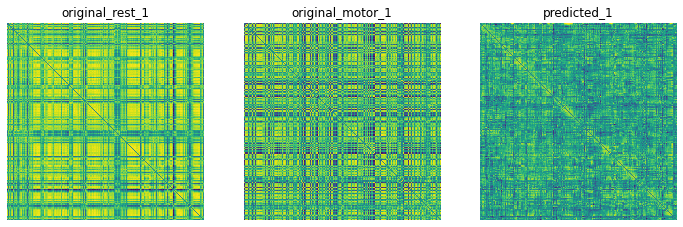

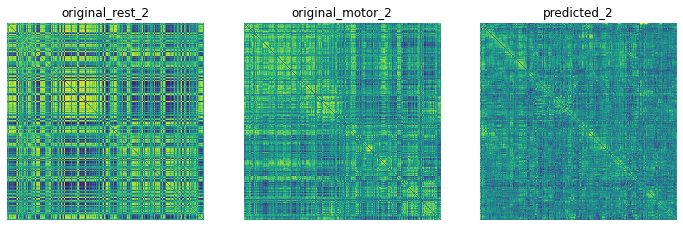

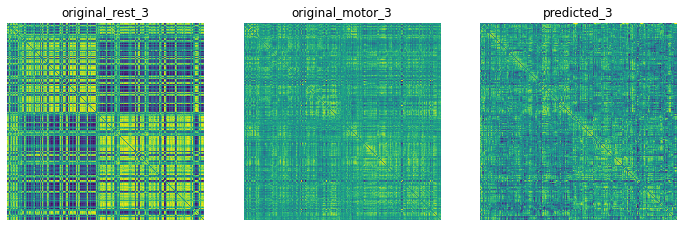

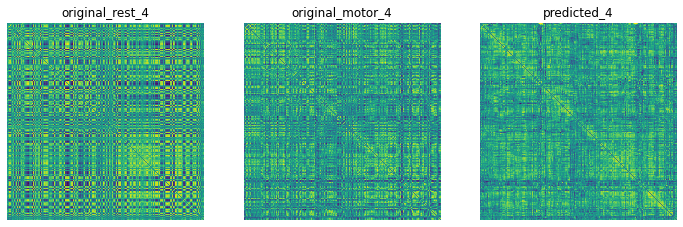

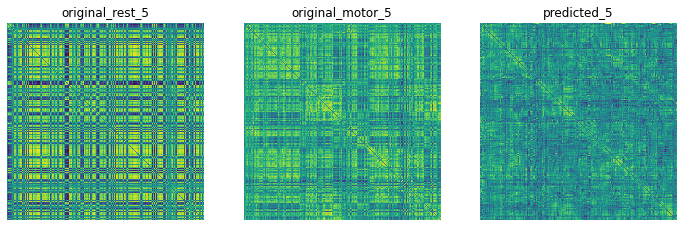

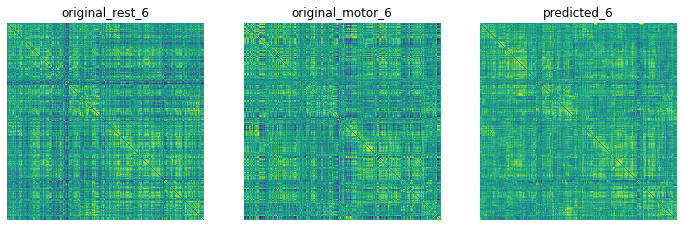

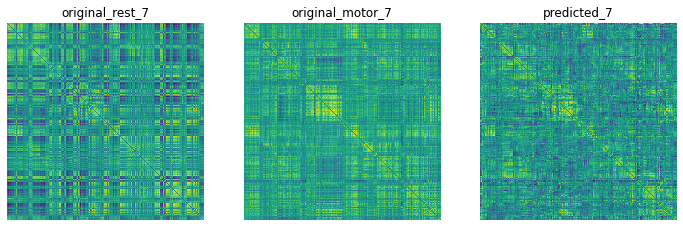

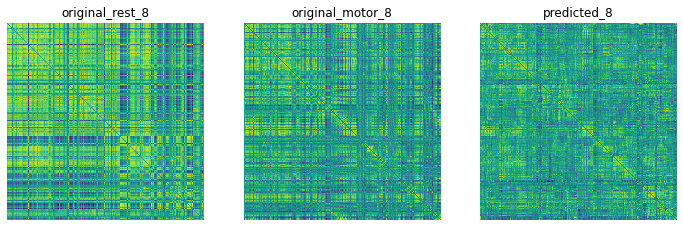

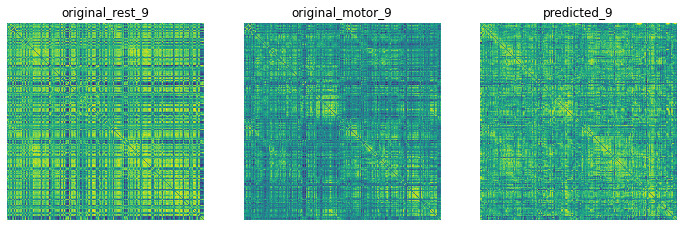

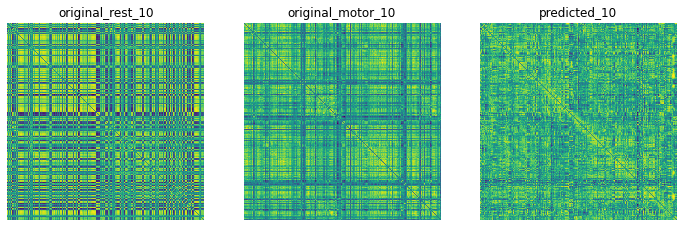

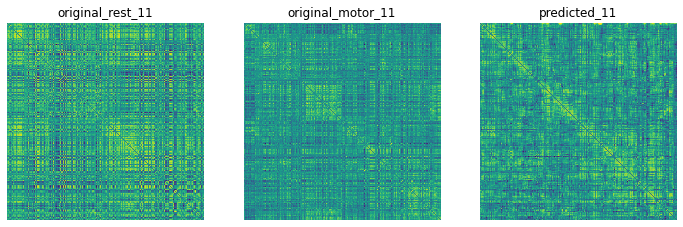

In [76]:
clear_output(wait=True)
with torch.no_grad():
            generated_motor = generator(test_data_rest.to(device))
            generated_motor = generated_motor.to('cpu')
            generated_motor1 = generator(test_data_rest_1.to(device))
            generated_motor1 = generated_motor1.to('cpu')
            generated_motor2 = generator(test_data_rest_2.to(device))
            generated_motor2 = generated_motor2.to('cpu')
            generated_motor3 = generator(test_data_rest_3.to(device))
            generated_motor3 = generated_motor3.to('cpu')
            generated_motor4 = generator(test_data_rest_4.to(device))
            generated_motor4 = generated_motor4.to('cpu')
            generated_motor5 = generator(test_data_rest_5.to(device))
            generated_motor5 = generated_motor5.to('cpu')
            generated_motor6 = generator(test_data_rest_6.to(device))
            generated_motor6 = generated_motor6.to('cpu')
            generated_motor7 = generator(test_data_rest_7.to(device))
            generated_motor7 = generated_motor7.to('cpu')
            generated_motor8 = generator(test_data_rest_8.to(device))
            generated_motor8 = generated_motor8.to('cpu')
            generated_motor9 = generator(test_data_rest_9.to(device))
            generated_motor9 = generated_motor9.to('cpu')
            generated_motor10 = generator(test_data_rest_10.to(device))
            generated_motor10= generated_motor10.to('cpu')
            plot_original_and_predicted(test_data_rest, test_data_motor, generated_motor, 'original_rest_1', 'original_motor_1', 'predicted_1')
            plot_original_and_predicted(test_data_rest_1, test_data_motor_1, generated_motor1, 'original_rest_2', 'original_motor_2', 'predicted_2')
            plot_original_and_predicted(test_data_rest_2, test_data_motor_2, generated_motor2, 'original_rest_3', 'original_motor_3', 'predicted_3')
            plot_original_and_predicted(test_data_rest_3, test_data_motor_3, generated_motor3, 'original_rest_4', 'original_motor_4', 'predicted_4')
            plot_original_and_predicted(test_data_rest_4, test_data_motor_4, generated_motor4, 'original_rest_5', 'original_motor_5', 'predicted_5')
            plot_original_and_predicted(test_data_rest_5, test_data_motor_5, generated_motor5, 'original_rest_6', 'original_motor_6', 'predicted_6')
            plot_original_and_predicted(test_data_rest_6, test_data_motor_6, generated_motor6, 'original_rest_7', 'original_motor_7', 'predicted_7')
            plot_original_and_predicted(test_data_rest_7, test_data_motor_7, generated_motor7, 'original_rest_8', 'original_motor_8', 'predicted_8')
            plot_original_and_predicted(test_data_rest_8, test_data_motor_8, generated_motor8, 'original_rest_9', 'original_motor_9', 'predicted_9')
            plot_original_and_predicted(test_data_rest_9, test_data_motor_9, generated_motor9, 'original_rest_10', 'original_motor_10', 'predicted_10')
            plot_original_and_predicted(test_data_rest_10, test_data_motor_10, generated_motor10, 'original_rest_11', 'original_motor_11', 'predicted_11')


In [96]:
mse_loss_motor_all = []
MSELoss = torch.nn.MSELoss()
with torch.no_grad():
    for batch_data in test_data_loader:
        rest_batch = batch_data["rest_fMRI_data"].to(device)  # Ensure data is on the same device as your model
        motor_batch = batch_data["motor_task_fMRI_data"].to(device)
        generated_motor =  generator(torch.tensor(rest_batch, device=device)).to(device)
        mse_loss_motor = MSELoss(generated_motor, motor_batch)
        mse_loss_motor_all.append(mse_loss_motor.cpu().detach().numpy())

        # # Plot the original and predicted "motor" task data
        # plot_original_and_predicted(rest_batch, motor_batch, generated_motor, 'Original Rest Data', 'Original Motor Data', 'Predicted Motor Task Data')
        # print("MSE:", mse_loss_motor.item())

<ipython-input-96-eafcc50cef47>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  generated_motor =  generator(torch.tensor(rest_batch, device=device)).to(device)


In [97]:
import numpy as np

average = np.mean(mse_loss_motor_all)

std_deviation = np.std(mse_loss_motor_all)

print("Mean MSE for pix2pix with 300 steps:", average)
print("Std for MSE:", std_deviation)

Mean MSE for pix2pix with 300 steps: 0.07205839
Std for MSE: 0.034222785


In [80]:
mse_loss_motor_all

[array(0.07496312, dtype=float32),
 array(0.08643462, dtype=float32),
 array(0.05540586, dtype=float32),
 array(0.07085326, dtype=float32),
 array(0.07629795, dtype=float32),
 array(0.07325771, dtype=float32),
 array(0.04198135, dtype=float32),
 array(0.0697877, dtype=float32),
 array(0.09988421, dtype=float32),
 array(0.03186918, dtype=float32),
 array(0.12281767, dtype=float32),
 array(0.07394907, dtype=float32),
 array(0.04872286, dtype=float32),
 array(0.05721566, dtype=float32),
 array(0.08135771, dtype=float32),
 array(0.05614249, dtype=float32),
 array(0.05881255, dtype=float32),
 array(0.06884566, dtype=float32),
 array(0.05736405, dtype=float32),
 array(0.06105651, dtype=float32),
 array(0.07510319, dtype=float32),
 array(0.06111477, dtype=float32),
 array(0.05640002, dtype=float32),
 array(0.04517642, dtype=float32),
 array(0.05636663, dtype=float32),
 array(0.05129406, dtype=float32),
 array(0.06108172, dtype=float32),
 array(0.15012093, dtype=float32),
 array(0.08611445, dt

**NEW MSE BASELINE ESTIMATION**

In [93]:
mse_loss_motor_all_1 = []
MSELoss = torch.nn.MSELoss()
with torch.no_grad():
    for batch_data in test_data_loader:
        rest_batch = batch_data["rest_fMRI_data"].to(device)  # Ensure data is on the same device as your model
        motor_batch = batch_data["motor_task_fMRI_data"].to(device)
        mean_motor_batch = torch.mean(motor_batch)
        mse_loss_motor = MSELoss(mean_motor_batch, motor_batch)
        mse_loss_motor_all_1.append(mse_loss_motor.cpu().detach().numpy())
mse_baseline = MSELoss(mean_motor_batch, motor_batch)
std_deviation_baseline = np.std(mse_loss_motor_all_1)        


  

/trinity/home/ruslan.kalimullin/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1, 400, 400])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [94]:
mse_baseline

tensor(0.1246, device='cuda:0')

In [95]:
std_deviation_baseline

0.023923252